In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//src/')

ic| str_path: ('D:\\Profile data Cardiff\\Cardiff University\\Energy Data - '
               'Documents\\General\\resources\\Equipment_gain_profile_TM59.xlsx')
    sheet_name: 'Normalised'
ic| sum_profile: 1.0


d:\Profile data Cardiff\Cardiff University\Energy Data - Documents\General\code\degree-days-analysis\notebooks
d:
Profile data Cardiff
Cardiff University
Energy Data - Documents
General
code
degree-days-analysis
notebooks
d:\


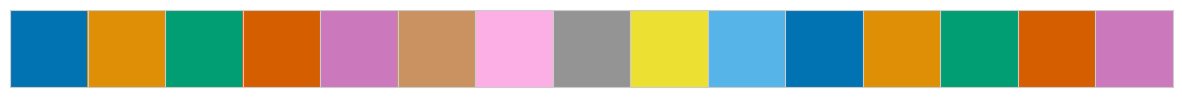

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import sys
import random
import geopandas as gpd
from common import enums, functions, schema
import main

from pathlib import Path

random.seed(42)

# blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
# sns.set_palette(sns.color_palette("Paired", 10))
# sns.set_style("white")
sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)


In [4]:
PATH_ORG = main.PATH_ORG
PATH_TABLES = PATH_ORG / r"General\communication\tables"
PATH_SAVE_FIGURES = PATH_ORG / r"General\communication\figures"
scop=14/3.412 #https://www.eia.gov/todayinenergy/detail.php?id=40232
cop = scop * 0.875

## Cooling demand in GB

In [5]:
residential_data = main.import_thermal_characteristics_data(
    main.PATH_GB_DATA / 'Thermal_characteristics_afterEE.csv', 2020, 2050)
residential_data.head()

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
Index,,,,,,,,,,,,,,,
0,S01006506,aberdeen city,North East Scotland,detached,gas boiler,17562.500000,0.273266,115,17533.867465,175.625000,low,-5,Edinburgh,S12000033,aberdeen city
1,S01006506,aberdeen city,North East Scotland,detached,oil boiler,26400.000000,0.299051,14,19188.338395,264.000000,low,-5,Edinburgh,S12000033,aberdeen city
2,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,26475.000000,0.390676,1,25067.327542,264.750000,low,-5,Edinburgh,S12000033,aberdeen city
3,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,11138.461538,0.216864,68,13914.831788,111.384615,low,-5,Edinburgh,S12000033,aberdeen city
4,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,8822.222222,0.113292,2,7269.253731,88.222222,low,-5,Edinburgh,S12000033,aberdeen city


In [6]:
residential_data[schema.DwellingDataSchema.NB_DWELLINGS].sum()/3

29362354.0

In [7]:
225000000/29362354.0

7.662873351366856

In [8]:
scenario_dict = {
    "high thermal capacity": ("high", '2050 high emission high thermal capacity') ,
    "medium thermal capacity": ("medium", '2050 high emission medium thermal capacity'),
    "low thermal capacity": ("low", '2050 high emission low thermal capacity') ,
}

In [9]:
import icecream as ic

peak_results = []
cooling_demand_results = []

for sc_name, (thermal_capacity_level, folder) in scenario_dict.items():
  ic.ic(sc_name)
  PATH_RESULTS = main.PATH_ORG / r'General\04 - Analysis' / folder
  try:
    cooling_demand = pd.read_csv(PATH_RESULTS /
                                 'cooling_demand_profiles_la.csv',
                                 index_col=0, parse_dates=True)
    lsoa_peak = pd.read_csv(PATH_RESULTS / 'cooling_peak_results_lsoa.csv',
                            index_col=[0, 1])
  except:
    filt = residential_data[schema.DwellingDataSchema.
                            THERMAL_CAPACITY_LEVEL] == thermal_capacity_level
    temp_residential_data = residential_data.loc[filt].copy()
    lsoa_peak, cooling_demand = functions.extract_cooling_demand_profiles_and_peaks(
        PATH_RESULTS, temp_residential_data)
  lsoa_peak[schema.DwellingDataSchema.
            THERMAL_CAPACITY_LEVEL] = thermal_capacity_level
  peak_results.append(lsoa_peak)
  total_cooling_demand = cooling_demand.sum(axis=1).to_frame()
  total_cooling_demand[schema.DwellingDataSchema.
                       THERMAL_CAPACITY_LEVEL] = thermal_capacity_level
  cooling_demand_results.append(total_cooling_demand)
lsoa_peak = pd.concat(peak_results)
lsoa_peak[schema.VisualisationSchema.PEAK_COOLING] = lsoa_peak[
      schema.VisualisationSchema.PEAK_COOLING] / 1000
cooling_demand = pd.concat(cooling_demand_results)
cooling_demand = pd.pivot_table(cooling_demand, index=cooling_demand.index, columns=schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL, values=0)

ic| sc_name: 'high thermal capacity'
ic| sc_name: 'medium thermal capacity'
ic| sc_name: 'low thermal capacity'


In [10]:
avg_cooling_demand = (cooling_demand.groupby(cooling_demand.index.hour).mean()/1000000)
avg_cooling_demand.head()

Thermal capacity level,high,low,medium
Time_(h),,,
0,0.102895,0.092604,0.101285
1,0.055338,0.046893,0.053516
2,0.014969,0.008746,0.013283
3,0.005835,0.001782,0.004561
4,0.002659,0.000535,0.001836


In [11]:
avg_cooling_demand.idxmax()

Thermal capacity level
high      16
low       15
medium    15
dtype: int32

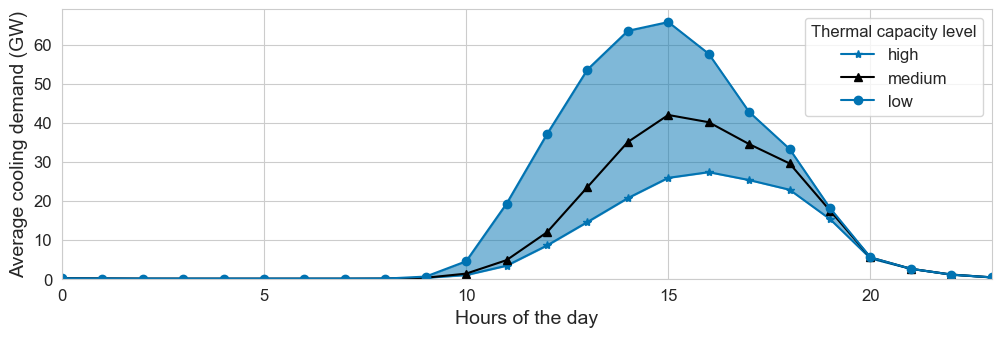

In [12]:
fig, ax = plt.subplots(figsize=figsize)
avg_cooling_demand['high'].plot(ax=ax, marker='*', color = sns.color_palette()[0])
avg_cooling_demand['medium'].plot(ax=ax, marker='^', color='black')
avg_cooling_demand['low'].plot(ax=ax, marker='o', color = sns.color_palette()[0])
ax.fill_between(avg_cooling_demand.index, avg_cooling_demand['high'],avg_cooling_demand['low'], color = sns.color_palette()[0], alpha=0.5)

ax.set_ylabel(schema.VisualisationSchema.AVG_COOLINGDEMAND_GW)
ax.set_xlim(0, 23)
ax.set_ylim(0, None)
ax.set_xlabel("Hours of the day")
ax.legend(title=schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL)

In [13]:
(cooling_demand.groupby(cooling_demand.index.hour).mean() /
 1000000).max()

Thermal capacity level
high      27.311218
low       65.777912
medium    41.963478
dtype: float64

Thermal capacity level
high      26.636062
low       62.050393
medium    38.234490
dtype: float64

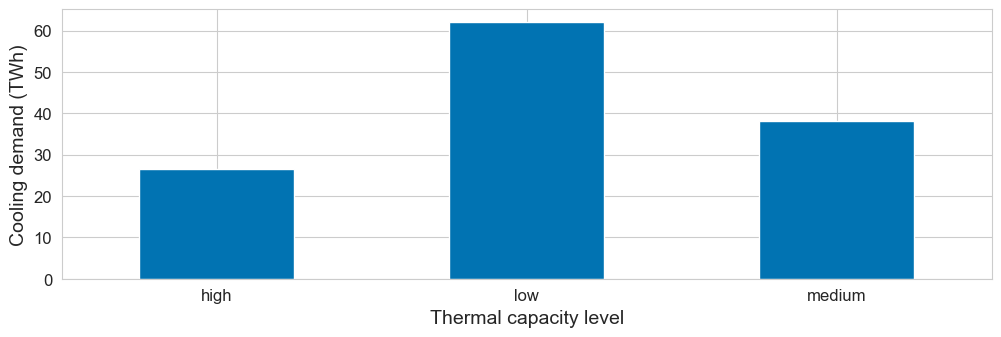

In [14]:
fig, ax = plt.subplots(figsize=figsize)
(cooling_demand / 1000000000).sum().plot.bar(ax=ax, rot=0)
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: "{:,.0f}".format(x)))
ax.set_ylabel(schema.VisualisationSchema.COOLINGDEMAND_TWH)
(cooling_demand / 1000000000).sum()

In [15]:
PATH_TABLES

WindowsPath('D:/Profile data Cardiff/Cardiff University/Energy Data - Documents/General/communication/tables')

In [16]:
summary_results = pd.concat([(cooling_demand / 1000000).max(),
                             (cooling_demand / 1000000000).sum()],
                            axis=1)
summary_results.columns = [
    schema.VisualisationSchema.COOLINGDEMAND_GW,
    schema.VisualisationSchema.COOLINGDEMAND_TWH
]
summary_results = summary_results.round(0).astype(int)
summary_results.to_csv(PATH_TABLES/"sensitivity_summary_results.csv")
summary_results

,Cooling demand (GW),Cooling demand (TWh)
Thermal capacity level,,
high,225,27
low,231,62
medium,225,38


In [17]:
(26636.061763-38234.490018)/38234.490018

-0.3033498877463698

In [18]:
(450 - 250) / 250
(62-38)/38

0.631578947368421

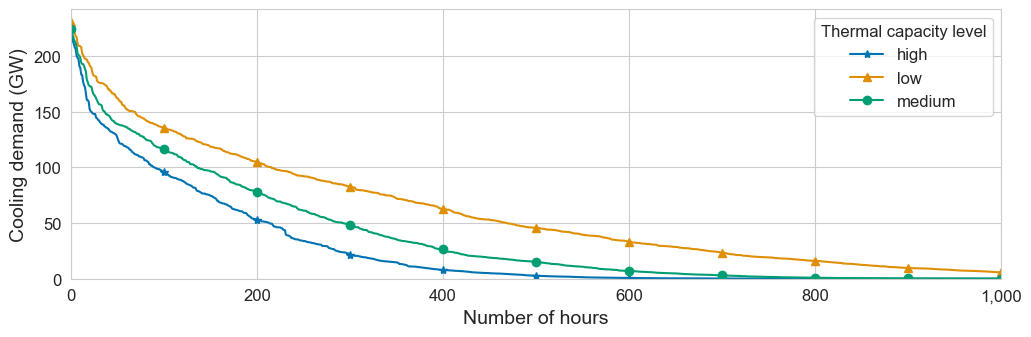

In [19]:
fig, ax = plt.subplots(figsize=figsize)
markers = ['*', '^', 'o']
for ii,c in enumerate(cooling_demand):
  (cooling_demand[c].sort_values(ascending=False).reset_index(drop=True)/1000000).plot(
      ax=ax, marker=markers[ii], markevery=100)
ax.margins(0, None)
ax.set_ylabel(schema.VisualisationSchema.COOLINGDEMAND_GW)
ax.set_xlabel("Number of hours")
ax.legend(title=schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL)
ax.set_xlim(0, 1000)
ax.set_ylim(0, None)
ax.get_xaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: "{:,.0f}".format(x)))
fig.savefig(PATH_SAVE_FIGURES/f"sensitivity_load_duration_curves.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"sensitivity_load_duration_curves.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

### Specific cooling demand by dwelling type, dwelling category and heating systems

<Axes: xlabel='Peak cooling demand (kW)', ylabel='Count'>

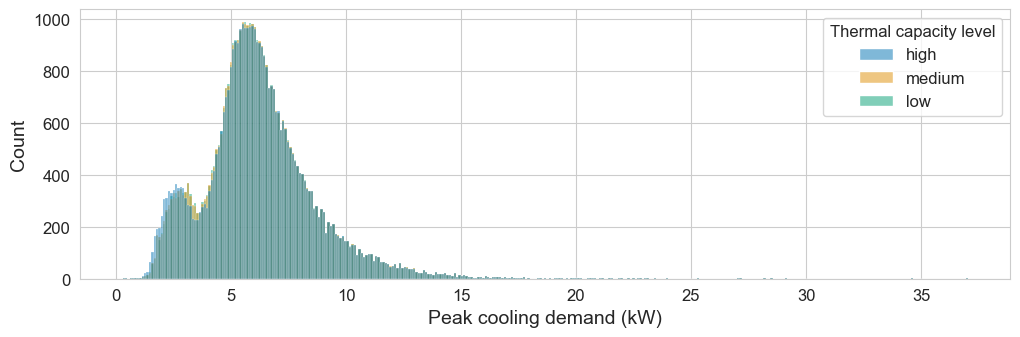

In [20]:
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(data= lsoa_peak.reset_index(drop=True), x=schema.VisualisationSchema.PEAK_COOLING, hue=schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL, ax=ax)